Импорт библиотек

In [1]:
import json
import os
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from src.nn import BayesianBinaryClassifier, BinaryClassifier

Функция для оценки метрик модели

In [2]:
def eval_metrics(
    model: BayesianBinaryClassifier | BinaryClassifier,
    x_train_tensor: torch.Tensor,
    y_train_tensor: torch.Tensor,
    x_test_tensor: torch.Tensor,
    y_test_tensor: torch.Tensor,
    n_samples: int = 5000,
) -> dict[str, float]:
    model.eval()
    sigmoid = torch.nn.Sigmoid().to(model.device)
    with torch.no_grad():
        y_pred_train_tensor = model(x_train_tensor.expand(n_samples, *x_train_tensor.shape))
        y_pred_prob_train_tensor: torch.Tensor = sigmoid(y_pred_train_tensor).mean(dim=0)
        y_pred_prob_train_tensor = y_pred_prob_train_tensor.view(y_pred_prob_train_tensor.shape[:-1])
        y_pred_prob_train: np.ndarray = y_pred_prob_train_tensor.cpu().detach().numpy()
        roc_auc_train = roc_auc_score(y_true=y_train_tensor.cpu().detach().numpy(), y_score=y_pred_prob_train)
        del (
            x_train_tensor,
            y_train_tensor,
            y_pred_train_tensor,
            y_pred_prob_train_tensor,
            y_pred_prob_train,
        )
        
        y_pred_test_tensor = model(x_test_tensor.expand(n_samples, *x_test_tensor.shape))
        y_pred_prob_test_tensor: torch.Tensor = sigmoid(y_pred_test_tensor).mean(dim=0)
        y_pred_prob_test_tensor = y_pred_prob_test_tensor.view(y_pred_prob_test_tensor.shape[:-1])
        y_pred_prob_test: np.ndarray = y_pred_prob_test_tensor.cpu().detach().numpy()
        roc_auc_test = roc_auc_score(y_true=y_test_tensor.cpu().detach().numpy(), y_score=y_pred_prob_test)
        
        return {
            "roc_auc_train": roc_auc_train.item(),
            "roc_auc_test": roc_auc_test.item(),
        }

Функция для проведения серии экспериментов сравнения классической и байесовой моделей

In [3]:
def make_experiments(
    x_train_tensor: torch.Tensor,
    y_train_tensor: torch.Tensor,
    x_test_tensor: torch.Tensor,
    y_test_tensor: torch.Tensor,
    n_hidden_init: int = 1,
    n_hidden_last: int = 128,
    n_hidden_step: int = 1,
):
    for dim_hidden in range(n_hidden_init, n_hidden_last + 1, n_hidden_step):
        model = BinaryClassifier(
            dim_in=x_train_tensor.shape[-1],
            dims_hidden=[dim_hidden],
            lr=0.01,
            backbone="Perceptrone",
            f_act="ReLU",
        ).cuda()
        model.fit(
            x=x_train_tensor,
            y=y_train_tensor,
            num_epoch=1_000,
            lr=0.01,
        )
        model.fit(
            x=x_train_tensor,
            y=y_train_tensor,
            num_epoch=1_000,
            lr=0.005,
        )
        model.eval()
        metrics_classic = eval_metrics(
            model=model,
            x_train_tensor=x_train_tensor,
            y_train_tensor=y_train_tensor,
            x_test_tensor=x_test_tensor,
            y_test_tensor=y_test_tensor,
            n_samples=1,
        )
        del model
        
        model = BayesianBinaryClassifier(
            dim_in=x_train_tensor.shape[-1],
            dims_hidden=[dim_hidden],
            lr=0.01,
            backbone="Perceptrone",
            f_act="ReLU",
        ).cuda()
        model.init(x=x_train_tensor, num_epoch=100, optimizer="SGD", lr=0.00001)
        model.fit(
            x=x_train_tensor,
            y=y_train_tensor,
            num_epoch=1_000,
            lr=0.01,
        )
        model.fit(
            x=x_train_tensor,
            y=y_train_tensor,
            num_epoch=1_000,
            lr=0.005,
        )
        model.fit(
            x=x_train_tensor,
            y=y_train_tensor,
            num_epoch=1_000,
            lr=0.001,
        )
        model.eval()
        metrics_bayesian = eval_metrics(
            model=model,
            x_train_tensor=x_train_tensor,
            y_train_tensor=y_train_tensor,
            x_test_tensor=x_test_tensor,
            y_test_tensor=y_test_tensor,
            n_samples=5000,
        )
        log = {
            "dim_hidden": dim_hidden,
            "metrics_classic": metrics_classic,
            "metrics_bayesian": metrics_bayesian,
        }
        with open(f"logs/dim_hidden_{dim_hidden}.json", "w") as f:
            json.dump(log, f)

Чтение данных и разбиение на трейн и тест

In [4]:
df = pd.read_csv("data/alzheimers_disease_data.csv").drop("DoctorInCharge", axis=1).set_index("PatientID")
x = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_mean = x_train.mean(axis=0)
x_std = x_train.std(axis=0)

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

x_train_tensor = torch.from_numpy(x_train.values).float().cuda()
y_train_tensor = torch.from_numpy(y_train.values).view(-1, 1).float().cuda()

x_test_tensor = torch.from_numpy(x_test.values).float().cuda()
y_test_tensor = torch.from_numpy(y_test.values).view(-1, 1).float().cuda()

Серия экспериментов сравнения классической и байесовой моделей

In [ ]:
make_experiments(
    x_train_tensor=x_train_tensor,
    y_train_tensor=y_train_tensor,
    x_test_tensor=x_test_tensor,
    y_test_tensor=y_test_tensor,
    n_hidden_init=1,
    n_hidden_last=32,
    n_hidden_step=1,
)

Чтение результатов экспериментов

In [6]:
data = []
for name in os.listdir("logs"):
    with open(f"logs/{name}") as f:
        item = json.load(f)
        metrics_classic = item.pop("metrics_classic")
        for metric_classic in metrics_classic:
            item[f"classic_{metric_classic}"] = metrics_classic[metric_classic]
        metrics_bayesian = item.pop("metrics_bayesian")
        for metric_bayesian in metrics_bayesian:
            item[f"bayesian_{metric_bayesian}"] = metrics_bayesian[metric_bayesian]
        data.append(item)
df = pd.DataFrame(data=data)
df = df.sort_values("dim_hidden").set_index("dim_hidden")
df

,classic_roc_auc_train,classic_roc_auc_test,bayesian_roc_auc_train,bayesian_roc_auc_test
dim_hidden,,,,
1,0.909121,0.893844,0.910386,0.901512
2,0.915644,0.877138,0.907610,0.899578
3,0.946971,0.910361,0.938819,0.934239
4,0.948725,0.880253,0.941852,0.929001
5,0.962470,0.890659,0.940973,0.932423
6,0.964945,0.869187,0.944939,0.937401
7,0.965665,0.841438,0.942939,0.932163
8,0.981103,0.841285,0.906661,0.899601
9,0.986517,0.840105,0.940631,0.931078


График зависимости ROC-AUC от количества нейронов в скрытом слое в однослойной полносвязной сети

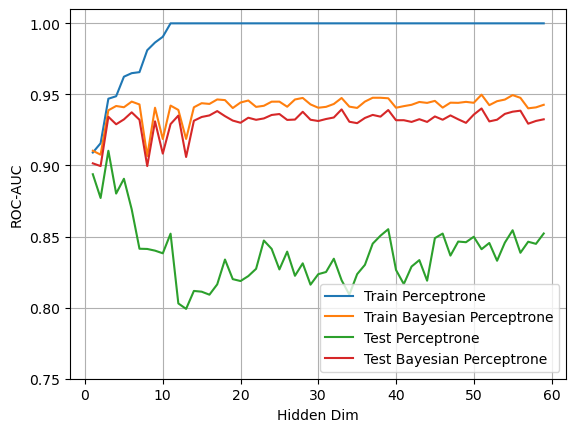

In [7]:
fig, ax = plt.subplots()
ax.plot(df.index, df["classic_roc_auc_train"], label="Train Perceptrone")
ax.plot(df.index, df["bayesian_roc_auc_train"], label="Train Bayesian Perceptrone")
ax.plot(df.index, df["classic_roc_auc_test"], label="Test Perceptrone")
ax.plot(df.index, df["bayesian_roc_auc_test"], label="Test Bayesian Perceptrone")
ax.set_xlabel("Hidden Dim")
ax.set_ylabel("ROC-AUC")
# ax.set_ylabel("$e^{-loss}$")
ax.legend()
ax.grid(True)
ax.set_ylim(bottom=0.75, top=1.01)
plt.show()

Расчёт корреляции ROC-AUC между Train и Test

In [8]:
df.corr(method="pearson").loc[["bayesian_roc_auc_train"], "bayesian_roc_auc_test"]

bayesian_roc_auc_train    0.973081
Name: bayesian_roc_auc_test, dtype: float64